In [68]:
import torch
import torchio as tio

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import filters, segmentation, morphology, measure, transform

from skimage import feature
import cv2
import scipy.signal as signal

from ipywidgets import interact
import ipywidgets as widgets

C:\Users\maell\AppData\Local\Temp\ipykernel_6916\13255774.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data)


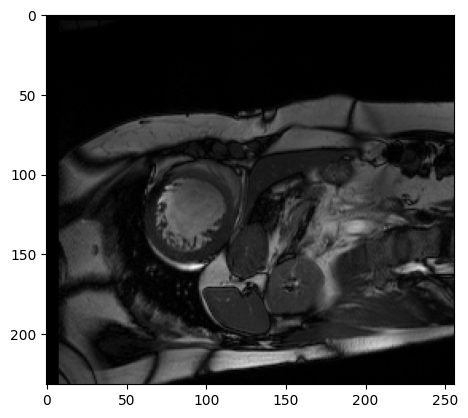

In [69]:
Tps = 0
Slice = 5

patient = tio.Subject(
    img=tio.ScalarImage('database/training/patient004/patient004_4d.nii.gz'),
)

t_img = torch.tensor(patient.img.data)
plt.imshow(t_img[Tps,:,:,Slice], cmap='gray')

In [70]:
def tf_mask(image4d, Tps=Tps, Slice=Slice):
    fft_img = torch.fft.fft(image4d, axis=0)
    filtred = fft_img
    filtred[:1, :, :, :] = 0.0
    filtred[3:, :, :, :] = 0.0

    timg2 = torch.abs(torch.fft.fft(filtred, axis=0))

    mask = np.array(timg2[Tps, :, :, Slice])
    mask = np.uint8(2*mask/np.max(mask)*255)
    kernel = np.ones((19, 19), np.uint8) 
    mask = cv2.dilate(mask, kernel, 1)
    mask = cv2.blur(mask,(21, 21))
    # print(np.max(mask))

    img_m = np.array(image4d[Tps, :, :, Slice], dtype=np.float64)
    img_m = np.uint8(img_m/np.max(img_m)*np.float64(mask))
    img_m = cv2.medianBlur(img_m,5)
    return img_m

In [71]:
img_m = tf_mask(t_img)
circles = cv2.HoughCircles(img_m, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=80,param2=40,minRadius=1,maxRadius=0)

In [72]:
def to_rgb(gray):
    return cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

In [73]:
def draw_cercles(image4d, circles=None, Tps=Tps, Slice=Slice):
  cimg = np.array(image4d[Tps, :, :, Slice])
  cimg = np.uint8(cimg/np.max(cimg)*255)
  cimg = to_rgb(cimg)
  if circles is not None:
    # print("circles !")
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
      cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),1)
      cv2.circle(cimg,(i[0],i[1]),1,(255,0,0),2)
  # else:
    # print("no circles !")
  return cimg

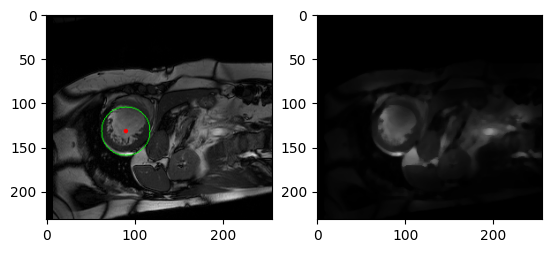

In [74]:
c_img = draw_cercles(t_img, circles)

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(c_img, vmin = 0, vmax=255)
ax2.imshow(img_m, cmap="grey", vmin = 0, vmax=255)

plt.show()

In [75]:
def recherche_cercles(nb):
    reussite = 0
    for i in range (1,nb):
        patient = tio.Subject(
            t1=tio.ScalarImage(f'database/training/patient{i:03d}/patient{i:03d}_4d.nii.gz'),
        )
        t_img = torch.tensor(patient.t1.data)
        img_m = tf_mask(t_img)
        circles = cv2.HoughCircles(img_m, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=80,param2=40,minRadius=1,maxRadius=0)
        if circles is not None:
            reussite += 1
        c_img = draw_cercles(t_img, circles)
        cv2.imwrite(f'test_seed/cercles_{i:03d}.png', c_img)
    print(f"Reussite : {reussite}/{nb}")

In [76]:
# recherche_cercles(21)

In [77]:
## On remarque que parfois , les parametres de Hough sont trop restructifs et parfois c'est l'inverse.
# On va donc essayer de se rapprocher par dichotomie, des parametres qui nous renvoient un seul cercle par image.
# On fixe minRadius=1 et maxRadius=50.
# On va chercher param1 et param2 tels que le nombre de cercles soit égal à 1.

def best_hough(image, Tps=Tps, Slice=Slice):
    param2 = 40
    param1 = 2*param2
    circles = None
    stop = 0
    exec = 0 if circles is None else len(circles[0])
    while exec != 1 and stop < 100:
        circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=param1,param2=param2,minRadius=1,maxRadius=50)
        if circles is None:
            param1 -= 1
            param2 = param1/2
        elif len(circles[0]) > 1:
            param1 += 1
            param2 = param1/2
        stop += 1
        exec = 0 if circles is None else len(circles[0])
    return circles, param1, param2

In [78]:
def recherche_cercles(nb):
    reussite = 0
    for i in range (1,nb+1):
        patient = tio.Subject(
            t1=tio.ScalarImage(f'database/training/patient{i:03d}/patient{i:03d}_4d.nii.gz'),
        )
        t_img = torch.tensor(patient.t1.data)
        img_m = tf_mask(t_img)
        circles, param1, param2 = best_hough(img_m)
        if circles is None:
            print(f"Impossible de trouver un cercle pour l'image {i}")
        elif len(circles[0]) == 1:
            reussite += 1
            print(f"circles pour {i} ! param1={param1} et param2={param2}")
        c_img = draw_cercles(t_img, circles)
        cv2.imwrite(f'test_seed/cercles_{i:03d}.png', c_img)
    print(f"Reussite : {reussite}/{nb}")

In [79]:
recherche_cercles(100)

C:\Users\maell\AppData\Local\Temp\ipykernel_6916\1278626225.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.t1.data)


circles pour 1 ! param1=80 et param2=40
circles pour 2 ! param1=80 et param2=40
circles pour 3 ! param1=66 et param2=33.0
circles pour 4 ! param1=80 et param2=40
circles pour 5 ! param1=74 et param2=37.0
Impossible de trouver un cercle pour l'image 6
circles pour 7 ! param1=80 et param2=40
circles pour 8 ! param1=62 et param2=31.0
circles pour 9 ! param1=79 et param2=39.5
circles pour 10 ! param1=74 et param2=37.0
circles pour 11 ! param1=80 et param2=40
circles pour 12 ! param1=80 et param2=40
circles pour 13 ! param1=73 et param2=36.5
circles pour 14 ! param1=77 et param2=38.5
circles pour 15 ! param1=80 et param2=40
circles pour 16 ! param1=80 et param2=40
circles pour 17 ! param1=80 et param2=40
circles pour 18 ! param1=80 et param2=40
circles pour 19 ! param1=80 et param2=40
circles pour 20 ! param1=78 et param2=39.0
circles pour 21 ! param1=45 et param2=22.5
circles pour 22 ! param1=61 et param2=30.5
circles pour 23 ! param1=78 et param2=39.0
circles pour 24 ! param1=57 et param2

In [102]:
def seed_point(n_patient: int):
    patient = tio.Subject(
        t1=tio.ScalarImage(f'database/training/patient{n_patient:03d}/patient{n_patient:03d}_4d.nii.gz'),
    )
    t_img = torch.tensor(patient.t1.data)
    img_m = tf_mask(t_img)
    circles, param1, param2 = best_hough(img_m)
    if circles is None:
        print(f"Impossible de trouver une seed pour le patient n°{n_patient}")
        return None
    elif len(circles[0]) == 1:
        print(f"seed trouvée de coordonnées {circles[0][0]} pour le patient n°{n_patient}")
        c_img = draw_cercles(t_img, circles)
        return circles[0][0][:2], c_img

In [103]:
def region_growth(image,seed,error=10):
    H,L=image.shape
    left_V = np.zeros_like(image)
    visited = np.zeros_like(image, dtype=bool)

    region=[seed]
    moy=image[seed[1],seed[0]]
    visited[seed[1],seed[0]]=True
    left_V[seed[1],seed[0]]=1

    while region:
        new_p=[]
        for (x,y) in region:
            for dx in [-1,0,1]:
                for dy in [-1,0,1]:
                    nx,ny=x+dx,y+dy
                    if 0<=nx<L and 0<=ny<H and not visited[ny,nx]:
                        if abs(image[ny,nx]-moy)<error:
                            new_p.append((nx,ny))
                            visited[ny,nx]=True
                            left_V[ny,nx]=1
        region.extend(new_p)
        if new_p:
            total_intensity=sum(image[ny,nx] for (nx,ny) in region)
            moy=total_intensity/len(region)
        region=new_p
    return left_V

In [110]:
def leftv_seg(nb_patient, error=10, Tps=Tps, Slice=Slice):
    patient = tio.Subject(
        t1=tio.ScalarImage(f'database/training/patient{nb_patient:03d}/patient{nb_patient:03d}_4d.nii.gz'),
    )
    seed_p = seed_point(nb_patient)
    if seed_p is None:
        return None
    else :
        seed,c_img = seed_p
        seed = (int(seed[0]), int(seed[1]))
        t_img = torch.tensor(patient.t1.data)
        lv_seg = region_growth(np.array(t_img[Tps,:,:,Slice]),seed, error)
        contours = measure.find_contours(lv_seg, 0.5)

        plt.figure(figsize=(15,5))

        plt.imshow(t_img[Tps,:,:,Slice], cmap='gray')
        plt.scatter(seed[0], seed[1], color='green')
        for contour in contours:
            plt.plot(contour[:, 1], contour[:, 0], linewidth=1, color='red')
        plt.legend(['Seed', 'Contours'])
        return lv_seg

C:\Users\maell\AppData\Local\Temp\ipykernel_6916\3226325993.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.t1.data)


seed trouvée de coordonnées [ 89.5 131.5  28.4] pour le patient n°4
(89, 131)


C:\Users\maell\AppData\Local\Temp\ipykernel_6916\1755203843.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.t1.data)


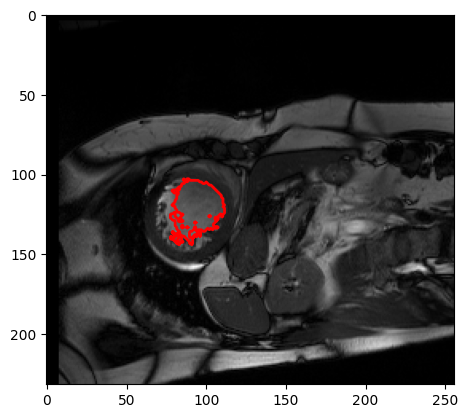

In [83]:
patient = tio.Subject(
    t1=tio.ScalarImage(f'database/training/patient004/patient004_4d.nii.gz'),
)
seed, c_img = seed_point(4)
seed = (int(seed[0]), int(seed[1]))
print(seed)

t_img = torch.tensor(patient.t1.data)

lv_seg = region_growth(np.array(t_img[Tps,:,:,Slice]), seed, 45)
contours = measure.find_contours(lv_seg, 0.5)

fig, ax = plt.subplots()
ax.imshow(t_img[Tps,:,:,Slice], cmap='gray')

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

plt.show()


C:\Users\maell\AppData\Local\Temp\ipykernel_6916\3226325993.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.t1.data)


seed trouvée de coordonnées [ 89.5 131.5  28.4] pour le patient n°4


C:\Users\maell\AppData\Local\Temp\ipykernel_6916\2192786725.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.t1.data)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

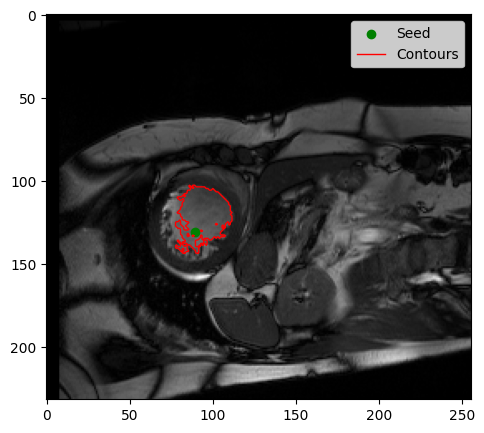

In [100]:
leftv_seg(4,45)

C:\Users\maell\AppData\Local\Temp\ipykernel_6916\3279787119.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.t1.data)


seed trouvée de coordonnées [133.5 100.5  17.2] pour le patient n°1


C:\Users\maell\AppData\Local\Temp\ipykernel_6916\96947871.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.t1.data)


seed trouvée de coordonnées [128.5 108.5  19.4] pour le patient n°2
seed trouvée de coordonnées [140.5 104.5  28. ] pour le patient n°3
seed trouvée de coordonnées [ 89.5 131.5  28.4] pour le patient n°4
seed trouvée de coordonnées [114.5 126.5  20.1] pour le patient n°5
Impossible de trouver une seed pour le patient n°6
seed trouvée de coordonnées [120.5 113.5  20.5] pour le patient n°7
seed trouvée de coordonnées [126.5  94.5  16.3] pour le patient n°8
seed trouvée de coordonnées [137.5  92.5  35. ] pour le patient n°9
seed trouvée de coordonnées [132.5 107.5  19.1] pour le patient n°10
seed trouvée de coordonnées [117.5  83.5  30.2] pour le patient n°11
seed trouvée de coordonnées [128.5  86.5  20.8] pour le patient n°12
seed trouvée de coordonnées [129.5 105.5  27.1] pour le patient n°13
seed trouvée de coordonnées [ 93.5 108.5  27.2] pour le patient n°14
seed trouvée de coordonnées [ 89.5 133.5  21.6] pour le patient n°15
seed trouvée de coordonnées [121.5  99.5  31.3] pour le pat

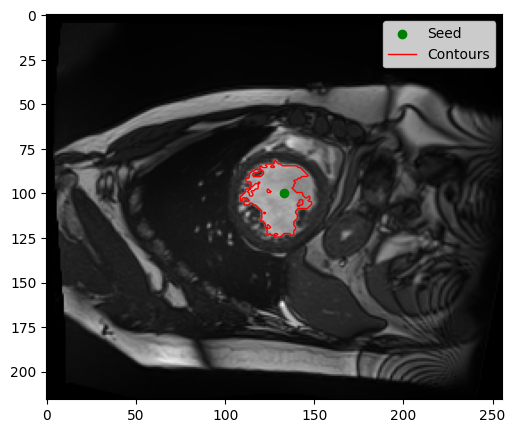

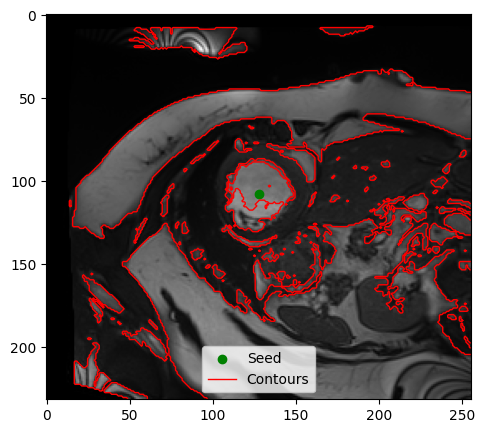

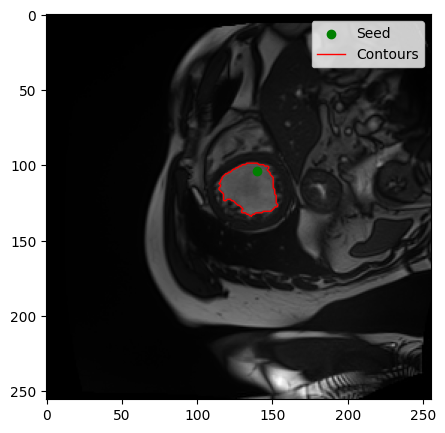

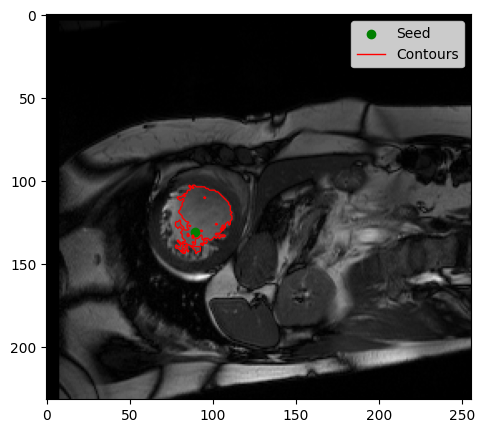

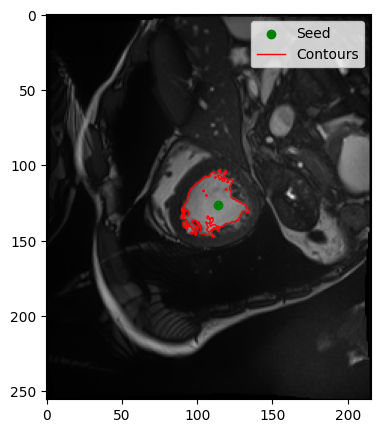

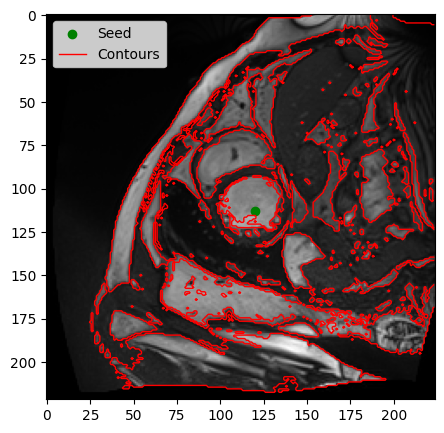

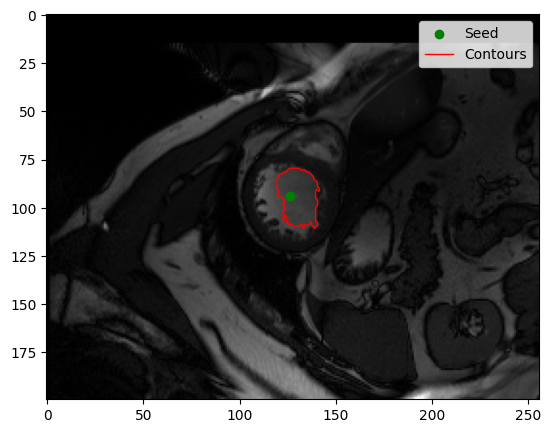

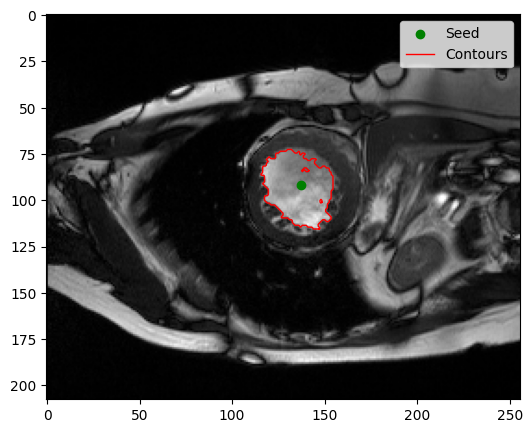

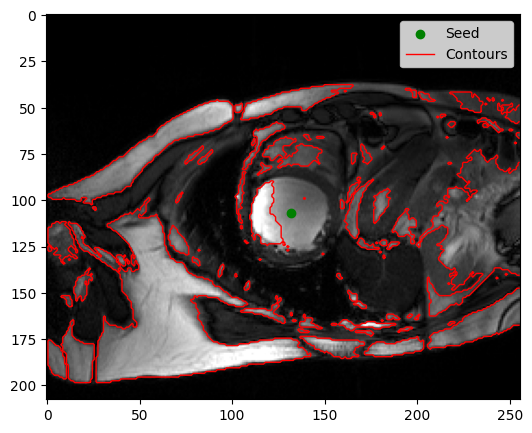

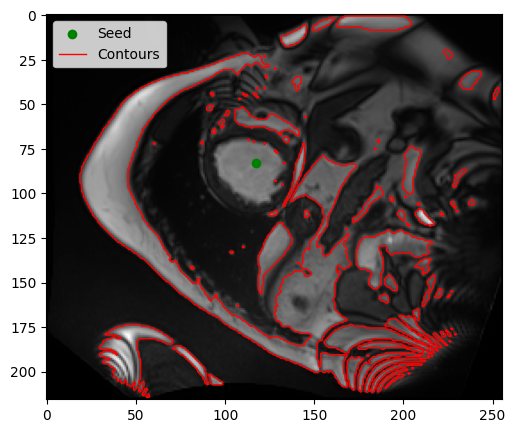

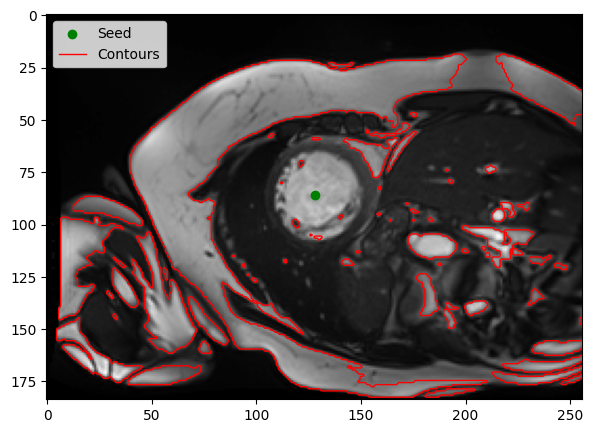

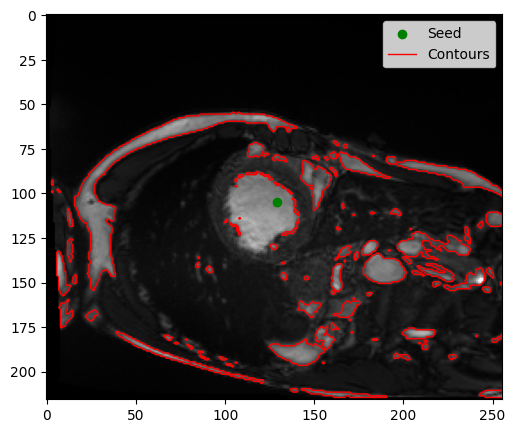

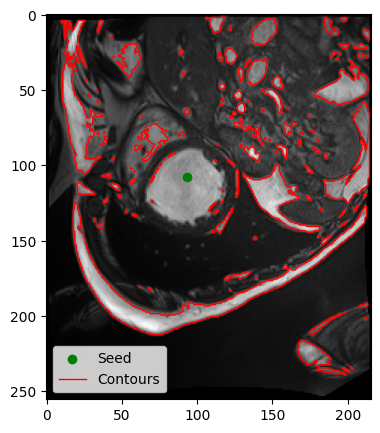

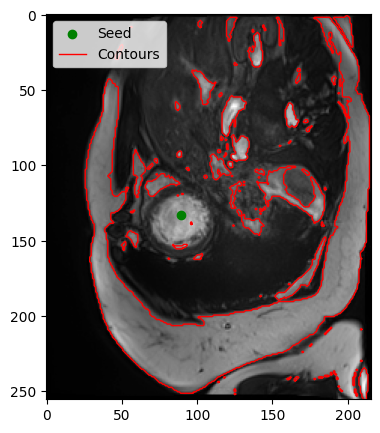

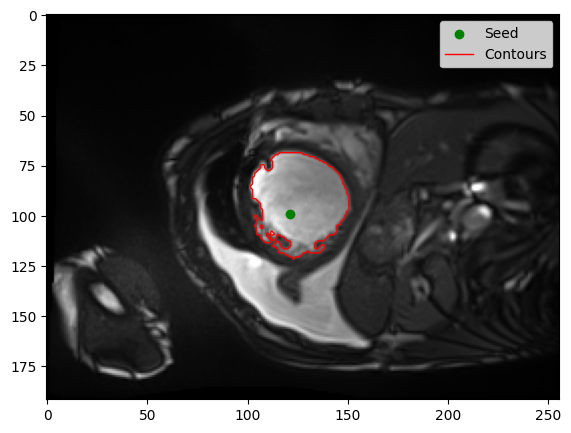

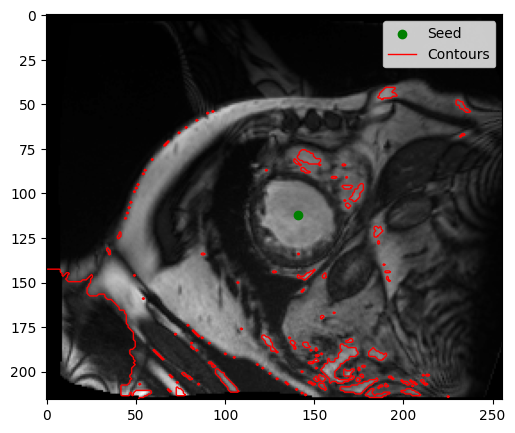

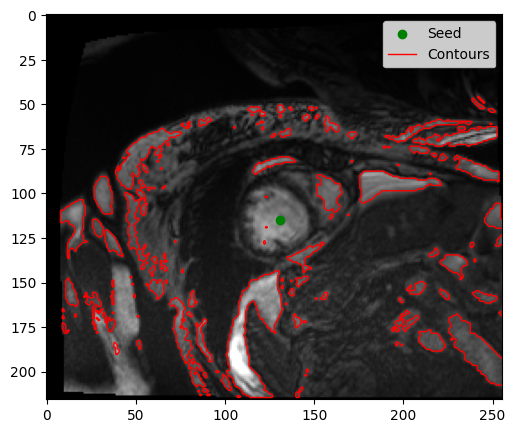

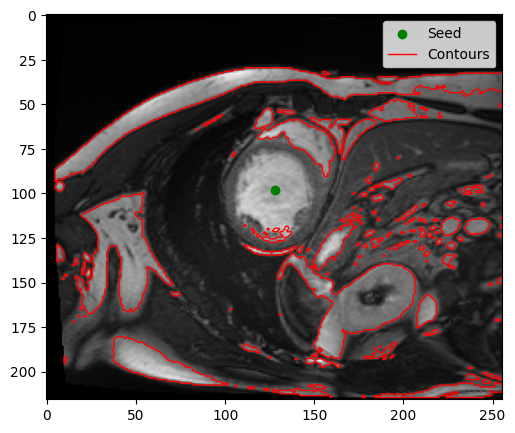

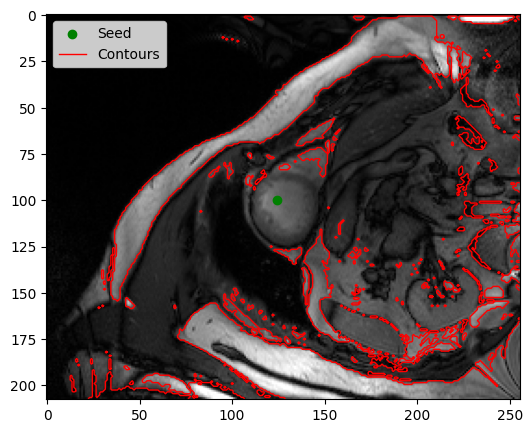

In [111]:
for i in range(1, 21):
    lv_seg = leftv_seg(int(i),error=40)
    plt.savefig(f'test_seg/lv_seg_{i:03d}.png')